#Mount Google Drive

This will allow the Colab machine to access Google Drive folders by mounting the drive on the machine. You will be asked to copy and paste an authentication code.

In [7]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# Change directory to allow imports


In [8]:
import os
os.chdir("/content/gdrive/My Drive/BoxDistContinued/")
!ls

Data  Documentation  Models  output  Outputs  References


##Import Libraries

In [9]:
# import some common libraries
from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import datetime
import random
import json
import cv2
import csv
import os
import h5py as h5

# import some common pytorch utilities
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch

##Set Directory

In [10]:
BASE_DIR = '/content/gdrive/My Drive/BoxDistContinued/'
TRAINING_DIR = os.path.join(BASE_DIR, 'Data/kitti/training')
OUTPUT_DIR = os.path.join(BASE_DIR, 'Outputs/agnoZDelta')
os.makedirs(OUTPUT_DIR, exist_ok=True)
TESTING_DIR = os.path.join(BASE_DIR, 'Data/kitti/testing')

###Network

In [11]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

def crop_pad(image, width=224, height=224):
  h, w = image.shape
  if h < height:
    image = cv2.copyMakeBorder(image, int((height-h)/2)+(height-h)%2, int((height-h)/2),0,0,cv2.BORDER_CONSTANT,value=[0,0,0])
  if w < width:
    image = cv2.copyMakeBorder(image,0,0,int((width-w)/2)+(width-w)%2, int((width-w)/2),cv2.BORDER_CONSTANT,value=[0,0,0])
  elif w > width:
    image = image[:, int((w-width)/2)+(w-width)%2:width+int((w-width)/2)+(w-width)%2]
  return image

def img_batch_con(inputs, num_imgs=3):
  batch = np.zeros((len(inputs), num_imgs, 224, 224))
  for i, input in enumerate(inputs):
    paths = input['2D']
    pre_tensor = np.zeros((num_imgs, 224, 224))
    imgs = {}
    shapes = []
    for j, path in enumerate(paths):
      f = h5.File(path, 'r')
      img = np.array(f['img'][:,:])
      h, w = img.shape
      shapes.append(h)
      imgs[j] = img
    for j in range(num_imgs):
      resized = crop_pad(image_resize(imgs[j], height=round(224*shapes[j]/max(shapes))))
      pre_tensor[j,:,:] = resized.astype(np.float32)/255.0

    batch[i,:,:,:] = pre_tensor

  batch = torch.from_numpy(batch.astype(np.float32)).cuda()
  return batch

def batch1D_con(inputs, interms):
  batch = np.zeros((len(inputs), 1000+33))
  for i, input in enumerate(inputs):
    D1 = input['1D']
    interm = interms[i].cpu().detach().numpy()
    combine = np.concatenate((interm, D1))
    batch[i,:] = combine
  batch = torch.from_numpy(batch.astype(np.float32)).cuda()
  return batch

def batch_output_con(inputs):
  batch = np.zeros((len(inputs), 3))
  for i, input in enumerate(inputs):
    batch[i,:] = np.array(input['output']).astype(np.float32)
  batch = torch.from_numpy(batch.astype(np.float32)).cuda()
  return batch

In [12]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

net2D = models.resnet18().cuda()

class CalcDist1D(nn.Module):
  def __init__(self):
    super(CalcDist1D, self).__init__()

    self.fc_net = nn.Sequential(
      nn.Linear(1000+33, 500),
      nn.LayerNorm(500),
      nn.Softplus(),
      nn.Linear(500, 250),
      nn.LayerNorm(250),
      nn.Softplus(),
      nn.Linear(250, 3),
    )
  def forward(self, x):
    x = self.fc_net(x)
    return x

net1D = CalcDist1D().cuda()

criterion = nn.L1Loss()

In [13]:
net2D.load_state_dict(torch.load("/content/gdrive/My Drive/BoxDistContinued/Models/trained/EndDist_res18_sp_2D_tr.pt"))
net1D.load_state_dict(torch.load("/content/gdrive/My Drive/BoxDistContinued/Models/trained/EndDist_res18_sp_1D_tr.pt"))

<All keys matched successfully>

##Load Test GT Labels (Expected Outputs)

In [14]:
set_names = ['0002', '0006', '0007', '0008', '0010', '0013', '0014', '0016', '0018']
#set_names = ['0000', '0001', '0003', '0004', '0005', '0009', '0011', '0012', '0015', '0017', '0019', '0020']

In [15]:
def load_gt_dists(set_names):
  gt_len = 0
  annotations = {}
  kitti_anno_dir = os.path.join(TESTING_DIR, 'label_02')
  tracking_anno_dir = os.path.join(TESTING_DIR, 'tracking_data/segmentations')

  for set_name in set_names:
    kitti_anno_file = os.path.join(kitti_anno_dir, set_name+'.txt')
    tracking_anno_file = os.path.join(tracking_anno_dir, set_name+'.txt')
    records = {}

    tracking_anno = open(tracking_anno_file, 'r')
    tracking_lines = tracking_anno.readlines()
    line = tracking_lines[0]
    e = line.split(' ')
    height = int(e[3])
    width = int(e[4])

#Load Kitti Annotations
    kitti_anno = open(kitti_anno_file, 'r')
    kitti_lines = kitti_anno.readlines()
    for line in kitti_lines:
      e = line.split(' ')
      class_name = e[2]
      trunc = float(e[3])
      occl = int(e[4])
      if (class_name != 'Car' and class_name != 'Pedestrian') or trunc > 0 or occl != 0: #data exclusion
        continue
      frame = int(e[0])
      obj_id = int(e[1])
      if frame not in records.keys():
        records[frame] = {}
      if obj_id not in records[frame].keys():
        records[frame][obj_id] = {}
      records[frame][obj_id] = {
          'class': class_name,
          'bbox': [float(e[6]), float(e[7]), float(e[8]), float(e[9])],
          'target': np.array([float(e[13]), float(e[14]), float(e[15])]).astype(np.float32),
          'centre': [((float(e[6])+(float(e[8])-float(e[6]))/2)-(width/2))/width, ((float(e[7])+(float(e[9])-float(e[7]))/2)-(height/2))/height]
      }
      gt_len += 1
    annotations[set_name] = records
  print('GT has %d object instances' %(gt_len))
  return annotations

In [16]:
gt_obj_dists = load_gt_dists(set_names)

GT has 6724 object instances


##Load Track-RCNN Detections & Frame IMU Data (Inputs)

In [17]:
from pycocotools import mask as cocomask

def load_track_imu(set_names):
  pred_len = 0
  annotations = {}
  tracking_anno_dir = os.path.join(TESTING_DIR, 'tracking_data/segmentations')
  detection_anno_dir = os.path.join(TESTING_DIR, 'tracking_data/detections')
  gps_anno_dir = os.path.join(TESTING_DIR, 'oxts')

  for set_name in set_names:
    tracking_anno_file = os.path.join(tracking_anno_dir, set_name+'.txt')
    detection_anno_file = os.path.join(detection_anno_dir, set_name+'.txt')
    gps_anno_file = os.path.join(gps_anno_dir, set_name+'.txt')
    records = {}

#Load GPS Annotations
    gps_anno = open(gps_anno_file, 'r')
    gps_lines = gps_anno.readlines()
    gps = {}
    for frame, line in enumerate(gps_lines):
      e = line.split(' ')
      v = [float(e[8]), float(e[9]), float(e[10])]
      a = [float(e[14]), float(e[15]), float(e[16])]
      w = [float(e[20]), float(e[21]), float(e[22])]
      gps[frame] = {
          'v': v,
          'a': a,
          'w': w,
      }
    
    tracking_anno = open(tracking_anno_file, 'r')
    tracking_lines = tracking_anno.readlines()
    for line in tracking_lines:
      e = line.split(' ')
      frame = int(e[0])
      if frame not in gps.keys():
        continue
      class_id = int(e[2])
      if class_id == 1:
        class_id = 0
      elif class_id == 2:
        class_id = 3
      obj_id = int(e[1])-1
      if frame not in records.keys():
        records[frame] = {}
        records[frame]['objs'] = {}
      height = int(e[3])
      width = int(e[4])
      records[frame]['height'] = height
      records[frame]['width'] = width
      records[frame]['v'] = gps[frame]['v']
      records[frame]['a'] = gps[frame]['a']
      records[frame]['w'] = gps[frame]['w']
      records[frame]['frame'] = frame
      rle_obj = {
          'counts': e[5],
          'size': [height, width]
      }
      #bbox = cocomask.toBbox(rle_obj) #outputs XYWH
      if obj_id not in records[frame]['objs'].keys():
        records[frame]['objs'][obj_id] = {}
      #records[frame]['objs'][obj_id]['bbox'] = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]
      records[frame]['objs'][obj_id]['rle'] = e[5].rstrip()
      records[frame]['objs'][obj_id]['class_id'] = class_id

    detection_anno = open(detection_anno_file, 'r')
    detection_lines = detection_anno.readlines()
    for line in detection_lines:
      e = line.split(' ')
      frame = int(e[0])
      confidence = float(e[5])
      if frame not in records.keys():
        continue
      bbox = [float(e[1]), float(e[2]), float(e[3]), float(e[4])]
      if 0.0 in bbox or width in bbox or height in bbox:# or confidence < 0.5 :
        continue
      rle = e[9].rstrip()
      for obj_id in records[frame]['objs'].keys():
        if records[frame]['objs'][obj_id]['rle'] == rle:
          records[frame]['objs'][obj_id]['bbox'] = bbox
          records[frame]['objs'][obj_id]['instance_img'] = TESTING_DIR + '/objs_raw/' + set_name + '/' + str(obj_id) + '/' + str(frame) + '.h5'
          break
        pred_len += 1


    annotations[set_name] = records
  
  print('TrackR-CNN has %d object instances' %(pred_len))
  return annotations

In [18]:
tracking_imu_data = load_track_imu(set_names)

TrackR-CNN has 169695 object instances


##Construct Model Inputs

In [19]:
def make_input(frame1, frame2, frame3):
  height = frame1['height']
  width = frame1['width']
  img_center = [width/2, height/2]

  #print(frame1, frame2, frame3)

  bh1 = frame1['bbox'][3] - frame1['bbox'][1]
  bw1 = frame1['bbox'][2] - frame1['bbox'][0]
  bh2 = frame2['bbox'][3] - frame2['bbox'][1]
  bw2 = frame2['bbox'][2] - frame2['bbox'][0]
  bh3 = frame3['bbox'][3] - frame3['bbox'][1]
  bw3 = frame3['bbox'][2] - frame3['bbox'][0]

  c1 = [(frame1['bbox'][0]+(bw1/2)-img_center[0])/(width/2), (frame1['bbox'][1]+(bh1/2)-img_center[1])/(height/2)]
  c2 = [(frame2['bbox'][0]+(bw2/2)-img_center[0])/(width/2), (frame2['bbox'][1]+(bh2/2)-img_center[1])/(height/2)]
  c3 = [(frame3['bbox'][0]+(bw3/2)-img_center[0])/(width/2), (frame3['bbox'][1]+(bh3/2)-img_center[1])/(height/2)]

  v1 = frame1['v']
  v2 = frame2['v']
  v3 = frame3['v']

  a1 = frame1['a']
  a2 = frame2['a']
  a3 = frame3['a']

  w1 = frame1['w']
  w2 = frame2['w']
  w3 = frame3['w']

  delta1 = bh2/bh1
  delta2 = bh3/bh2

  input = {
      '2D': [frame1['instance_img'], frame2['instance_img'], frame3['instance_img']],
      '1D': np.array(v1 + v2 + v3 + a1 + a2 + a3 + w1 + w2 + w3 + c1 + c2 + c3).astype(np.float32),
  }
  return input

##Measure Accuracy

###Pred/Target Alignment

In [20]:
def bbox_overlap_ratio(bbox0, bboxs):
  ratios = []
  area0 = (bbox0[2]-bbox0[0]) * (bbox0[3]-bbox0[1])
  for bbox in bboxs:
    x_left = max(bbox0[0], bbox[0])
    y_top = max(bbox0[1], bbox[1])
    x_right = min(bbox0[2], bbox[2])
    y_bottom = min(bbox0[3], bbox[3])
    if x_right < x_left or y_bottom < y_top:
      iou = 0.0
      ratios.append(iou)
    else:
      intersection_area = (x_right - x_left) * (y_bottom - y_top)
      bb1_area = (bbox0[2] - bbox0[0]) * (bbox0[3] - bbox0[1])
      bb2_area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
      iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
      ratios.append(iou)

  return ratios

def align_input_to_gt(inputs, gts):
  input_bboxs = []
  gt_bboxs = []
  for input in inputs:
    #numpy_input = input.detach().cpu().numpy()
    input_bbox = input['bbox']
    input_bboxs.append(input_bbox)
  for obj_id in gts.keys():
    gt_bbox = gts[obj_id]['bbox']
    gt_bboxs.append(gt_bbox)

  #print(input_bboxs)
  #print(gt_bboxs)
  
  ratio_table = []
  for gt_bbox in gt_bboxs:
    ratios = bbox_overlap_ratio(gt_bbox, input_bboxs)
    ratio_table.append(ratios)
  ratio_table = np.array(ratio_table)

  alignments = [-1]*len(gts)

  gt_maxs = []
  for i in range(len(gts)):
    gt_maxs.append(np.argmax(ratio_table[i, :]))
  input_maxs = []
  for i in range(len(inputs)):
    input_maxs.append(np.argmax(ratio_table[:, i]))

  for me, want in enumerate(gt_maxs):
    if input_maxs[want] == me and ratio_table[me, want] > 0.0:
      alignments[me] = want

  return alignments

###Measure

In [21]:
import math
def dist_3D(xyz):
  x = xyz[0][0]
  y = xyz[0][1]
  z = xyz[0][2]
  return math.sqrt(x**2+y**2+z**2)

output_records = []
target_records = []
n = 0
abs_errors = []
rel_errors = []
preds = []
dists = []
rmse = []

results = []

net2D.eval()
net1D.eval()
for set_name in set_names:
  prev_data = {}
  for frame in gt_obj_dists[set_name].keys():
    if frame not in tracking_imu_data[set_name].keys():
      continue
    inputs = []
    for_aligns = []
    for obj_id in tracking_imu_data[set_name][frame]['objs']:
      this_frame = tracking_imu_data[set_name][frame]
      if obj_id in prev_data.keys() and frame-5 in prev_data[obj_id].keys() and frame-10 in prev_data[obj_id].keys() and 'bbox' in this_frame['objs'][obj_id].keys():
        frame1 = prev_data[obj_id][frame-5]
        frame2 = prev_data[obj_id][frame-10]
        if 'bbox' in frame1['objs'][obj_id].keys() and 'bbox' in frame2['objs'][obj_id].keys():
          frame1 = {
              'v': frame1['v'],
              'a': frame1['a'],
              'w': frame1['w'],
              'bbox': frame1['objs'][obj_id]['bbox'],
              'height': frame1['height'], 
              'width': frame1['width'],
              'instance_img': frame1['objs'][obj_id]['instance_img'],
          }
          frame2 = {
              'v': frame2['v'],
              'a': frame2['a'],
              'w': frame2['w'],
              'bbox': frame2['objs'][obj_id]['bbox'],
              'height': frame2['height'], 
              'width': frame2['width'],
              'instance_img': frame2['objs'][obj_id]['instance_img'],
          }
          frame3 = {
              'v': this_frame['v'],
              'a': this_frame['a'],
              'w': this_frame['w'],
              'bbox': this_frame['objs'][obj_id]['bbox'],
              'height': this_frame['height'], 
              'width': this_frame['width'],
              'instance_img': this_frame['objs'][obj_id]['instance_img'],
          }
          input = make_input(frame1, frame2, frame3)
          inputs.append(input)
          for_aligns.append(frame3)
      if obj_id not in prev_data.keys():
        prev_data[obj_id] = {}
      prev_data[obj_id][frame] = this_frame

    if len(inputs) == 0:
      continue

    outputs = []
    with torch.no_grad():
      for input in inputs:
        input2D = img_batch_con([input])
        interm = net2D(input2D)
        input1D = batch1D_con([input], interm)
        output = net1D(input1D)
        outputs.append(output)
    
    frame_gt = gt_obj_dists[set_name][frame]

    alignment = align_input_to_gt(for_aligns, frame_gt)

    targets = []
    tar_classes = []

    for obj_id in frame_gt.keys():
      targets.append(frame_gt[obj_id]['target'])
      tar_classes.append(frame_gt[obj_id]['class'])
    
    for t, o in enumerate(alignment):
      if o == -1:
        continue
      output = outputs[o]
      target = targets[t]

      dist_tar = dist_3D(np.expand_dims(target,axis=0))
      dist_out = dist_3D(output.cpu().detach().numpy())

      results.append({
          'pred': dist_out,
          'targ': dist_tar,
          'class': tar_classes[t]
      })

      abs_errors.append(abs(dist_tar-dist_out))
      rel_errors.append(abs((dist_tar-dist_out)/dist_tar))

      output_records.append(dist_out)
      target_records.append(dist_tar)
      rmse.append((dist_tar-dist_out)**2)
      preds.append(dist_out)
      dists.append(dist_tar)
      n += 1

print('num aligned samples: %d' %(n))
print('mean absolute error: %.3fm' %(np.mean(abs_errors)))
print('mean relative error: %.3f' %(np.mean(rel_errors)))
print('median absolute error: %.3fm' %(np.median(np.sort(abs_errors))))
print('median relative error: %.3f' %(np.median(np.sort(rel_errors))))
rmse = sum(rmse)
rmse /= n
rmse = math.sqrt(rmse)
print(rmse)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


num aligned samples: 4720
mean absolute error: 4.566m
mean relative error: 0.164
median absolute error: 2.523m
median relative error: 0.118
7.201878306698904


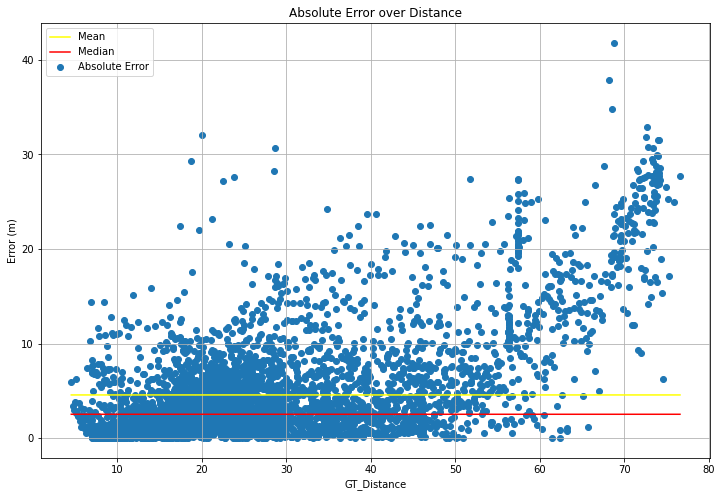

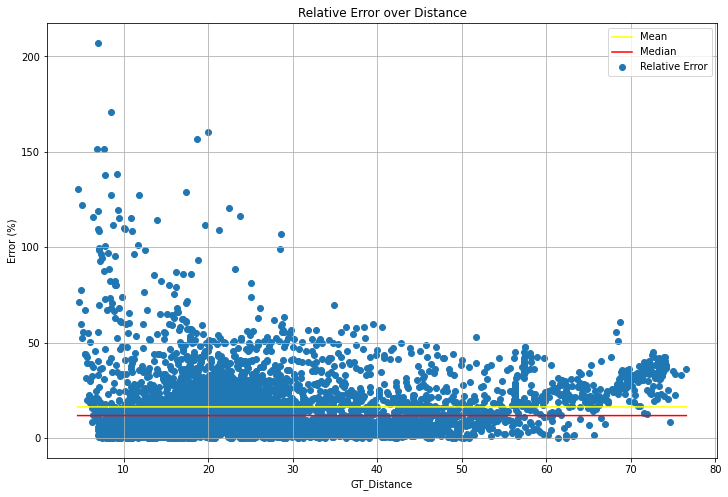

In [22]:
import matplotlib
import matplotlib.pyplot as plt

ordered_abs = [x for _, x in sorted(zip(dists, abs_errors))]
ordered_rel = [x for _, x in sorted(zip(dists, rel_errors))]

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax.scatter(np.sort(dists), np.array(ordered_abs), label='Absolute Error')
p = np.poly1d(np.polyfit(dists, ordered_abs, 10))
xp = np.linspace(min(dists), max(dists), len(dists))
#ax.plot(xp, p(xp), color='orange')
ax.plot(np.sort(dists), np.array([np.mean(abs_errors)]*n), color='yellow', label='Mean')
ax.plot(np.sort(dists), np.array([np.median(np.sort(abs_errors))]*n), color='red', label='Median')
ax.set(xlabel='GT_Distance', ylabel='Error (m)',
       title='Absolute Error over Distance')
ax.grid()
ax.legend()
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax.scatter(np.sort(dists), np.array(ordered_rel)*100, label='Relative Error')
p = np.poly1d(np.polyfit(dists, np.array(ordered_rel)*100, 10))
xp = np.linspace(min(dists), max(dists), len(dists))
#ax.plot(xp, p(xp), color='orange')
ax.plot(np.sort(dists), np.array([np.mean(rel_errors)*100]*n), color='yellow', label='Mean')
ax.plot(np.sort(dists), np.array([np.median(np.sort(rel_errors))*100]*n), color='red', label='Median')
ax.set(xlabel='GT_Distance', ylabel='Error (%)',
       title='Relative Error over Distance')
ax.grid()
ax.legend()
plt.show()


In [23]:
import csv

with open('/content/gdrive/My Drive/BoxDistContinued/Models/EndDist/Results/res18_sp_tr_tr.csv', 'w', newline='') as csvfile:
    fieldnames = ['class', 'target', 'prediction']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for r in results:
      writer.writerow({'class': r['class'], 'target': r['targ'], 'prediction': r['pred']})
